In [2]:
%tensorflow_version 2.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [3]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

valid_set_size_percentage = 10 
test_set_size_percentage = 10 

print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

/: ['run', 'sbin', 'var', 'root', 'mnt', 'sys', 'proc', 'opt', 'media', 'home', 'tmp', 'etc', 'boot', 'dev', 'bin', 'usr', 'lib64', 'srv', 'lib', 'content', '.dockerenv', 'datalab', 'tools', 'swift', 'dlib-19.18.0-cp36-cp36m-linux_x86_64.whl', 'tensorflow-1.15.0', 'dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl', 'lib32']
/content: ['.config', 'sample_data']


In [8]:
df = pd.read_csv("./sample_data/dataset.csv", index_col = 0)
df.info()
df.head()

print('\number of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

<class 'pandas.core.frame.DataFrame'>
Index: 16884 entries, 2016-01-05 to 2010-02-24
Data columns (total 6 columns):
symbol    16884 non-null object
open      16884 non-null float64
close     16883 non-null float64
low       16883 non-null float64
high      16883 non-null float64
volume    16883 non-null float64
dtypes: float64(5), object(1)
memory usage: 923.3+ KB

umber of different stocks:  469
['JNPR', 'RHT', 'HAL', 'ZION', 'LEN', 'SYMC', 'HRL', 'TGNA', 'URI', 'TJX']


In [9]:
df.tail()

,symbol,open,close,low,high,volume
date,,,,,,
2010-02-24,KSS,51.150002,51.590000,50.500000,51.669998,4503500.0
2010-02-24,KSU,34.419998,34.320000,34.040001,34.669998,887200.0
2010-02-24,L,36.099998,36.619999,36.090000,36.650002,1756000.0
2010-02-24,LB,20.870001,21.540001,20.870001,21.559999,7085800.0
2010-02-24,LEG,19.290000,NaN,NaN,NaN,NaN


In [10]:
df.describe()

,open,close,low,high,volume
count,16884.000000,16883.000000,16883.000000,16883.000000,1.688300e+04
mean,39.647983,39.632456,39.135171,40.090366,7.597947e+06
std,33.780615,33.744706,33.365601,34.111813,1.812141e+07
min,3.680000,3.680000,3.650000,3.740000,0.000000e+00
25%,20.940001,20.920000,20.672500,21.180000,1.531750e+06
50%,31.705000,31.700001,31.309999,32.042369,3.250300e+06
75%,47.779999,47.750000,47.125000,48.318029,6.963400e+06
max,348.989990,346.989990,344.019989,349.500000,5.512855e+08


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16884 entries, 2016-01-05 to 2010-02-24
Data columns (total 6 columns):
symbol    16884 non-null object
open      16884 non-null float64
close     16883 non-null float64
low       16883 non-null float64
high      16883 non-null float64
volume    16883 non-null float64
dtypes: float64(5), object(1)
memory usage: 923.3+ KB


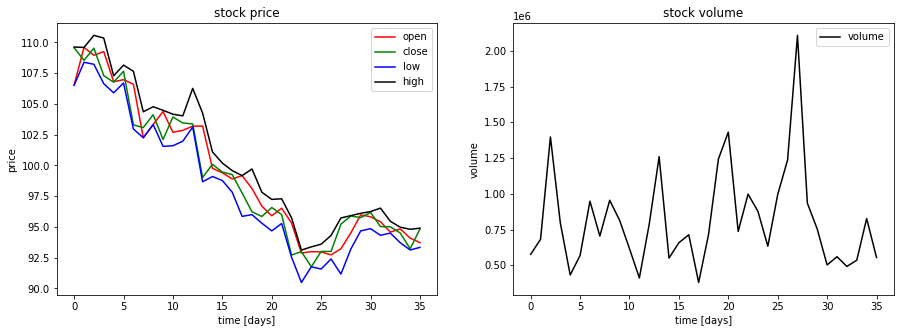

In [12]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [13]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df


def load_data(stock, seq_len):
    data_raw = stock.as_matrix() 
    data = []
    
   
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['open', 'close', 'low', 'high']
x_train.shape =  (12, 19, 4)
y_train.shape =  (12, 4)
x_valid.shape =  (2, 19, 4)
y_valid.shape =  (2, 4)
x_test.shape =  (2, 19, 4)
y_test.shape =  (2, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


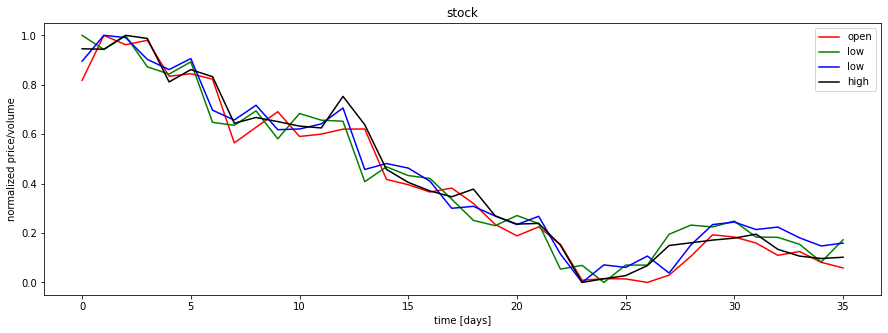

In [14]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')

plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [17]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size

    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) 
        start = 
        index_in_epoch = batch_size

        end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] 
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size)

        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
           mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
           mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
           print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 0.114782/0.039750
4.17 epochs: MSE train/valid = 0.268742/0.177845
8.33 epochs: MSE train/valid = 0.024717/0.011242
12.50 epochs: MSE train/valid = 0.041637/0.015636
16.67 epochs: MSE train/valid = 0.018299/0.011496
20.83 epochs: MSE train/valid = 0.022404/0.019802
25.00 epochs: MSE train/valid = 0.026292/0.020038
29.17 epochs: MSE train/valid = 0.014768/0.014998
33.33 epochs: MSE train/valid = 0.008091/0.013077
37.50 epochs: MSE train/valid = 0.008538/0.012295
41.67 epochs: MSE train/valid = 0.009488/0.010398
45.83 epochs: MSE train/valid = 0.007759/0.007758
50.00 epochs: MSE train/valid = 0.005764/0.006250
54.17 epochs: MSE train/valid = 0.005703/0.006496
58.33 epochs: MSE train/valid = 0.006266/0.006962
62.50 epochs: MSE train/valid = 0.006255/0.006584
66.67 epochs: MSE train/valid = 0.005707/0.005524
70.83 epochs: MSE train/valid = 0.004536/0.004041
75.00 epochs: MSE train/valid = 0.003600/0.002771
79.17 epochs: MSE train/valid = 0.003534/0.002297
83.

In [18]:
y_train.shape

(12, 4)

In [4]:
loss_RNN, acc_RNN = model_RNN.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % (acc_RNN*100), "%")
print("Loss: %.2f" % (loss_RNN*100), "%")

NameError: ignored